In [1]:
import os
os.chdir('/home/dlhogan/GitHub/Synoptic-Sublimation/')

In [1]:
# general
import datetime as dt
# data 
import xarray as xr 
import numpy as np
import pandas as pd
# plotting
import plotly.graph_objects as go
from plotly.subplots import make_subplots
import cufflinks as cf
from plotly.offline import download_plotlyjs, init_notebook_mode, plot, iplot
import plotly.io as pio
# helper tools
from utils.helper_funcs import create_windrose_df
import utils.helper_funcs as hf
from metpy import calc, units
from windrose import WindroseAxes
# make plotly work 
init_notebook_mode(connected=True)
cf.go_offline()

In [2]:
# Import SAIL met data
winter_22 = slice('2021-12-01', '2022-03-31')
winter_23 = slice('2022-12-01', '2023-03-31')
# Set the location of the data folder where this data will be stored
winter_22_folder = 'winter_21_22'
winter_23_folder = 'winter_22_23'
# change to location of data folder on your machine
storage_directory = f'/storage/dlhogan/synoptic_sublimation/sail_data'

w22_sail_met_ds = xr.open_dataset(f'{storage_directory}/{winter_22_folder}/met_20211001_20220930.nc')
w23_sail_met_ds = xr.open_dataset(f'{storage_directory}/{winter_23_folder}/met_20221001_20230930.nc')

# load the kettle ponds data
w22_sail_kettle_ponds = xr.open_dataset(f'{storage_directory}/{winter_22_folder}/eddy_covariance_kettle_ponds_noqc_20211001_20220930.nc')
w23_sail_kettle_ponds = xr.open_dataset(f'{storage_directory}/{winter_23_folder}/eddy_covariance_kettle_ponds_noqc_20221001_20230930.nc')

# filter to only include the winter months
w22_sail_met_ds = w22_sail_met_ds.sel(time=winter_22)
w23_sail_met_ds = w23_sail_met_ds.sel(time=winter_23)
w22_sail_kettle_ponds = w22_sail_kettle_ponds.sel(time=winter_22)
w23_sail_kettle_ponds = w23_sail_kettle_ponds.sel(time=winter_23)

VARIABLES = ['atmos_pressure','temp_mean', 'rh_mean','vapor_pressure_mean','wspd_arith_mean','wdir_vec_mean']
VARIABLES_KP = ['mean_u','mean_v','mean_t','mean_q','atm_pres','wind_spd','wind_dir','lv']
# qc the data
w22_sail_met_qc_ds = hf.qc_sail_met(w22_sail_met_ds,VARIABLES, 'temp_mean', 'rh_mean', 'wspd_arith_mean', 'vapor_pressure_mean')
w23_sail_met_qc_ds = hf.qc_sail_met(w23_sail_met_ds,VARIABLES, 'temp_mean', 'rh_mean', 'wspd_arith_mean', 'vapor_pressure_mean')
w23_sail_met_kp_qc_ds = hf.qc_sail_met(w23_sail_kettle_ponds, VARIABLES_KP, 'mean_t', 'mean_q', 'wind_spd', 'mean_q')
w22_sail_met_kp_qc_ds = hf.qc_sail_met(w22_sail_kettle_ponds, VARIABLES_KP, 'mean_t', 'mean_q', 'wind_spd', 'mean_q')

atmos_pressure has 0 nan values
temp_mean has 0 nan values
rh_mean has 0 nan values
vapor_pressure_mean has 0 nan values
wspd_arith_mean has 8 nan values
wdir_vec_mean has 0 nan values
-------------------
atmos_pressure has 0 nan values
temp_mean has 0 nan values
rh_mean has 0 nan values
vapor_pressure_mean has 0 nan values
wspd_arith_mean has 0 nan values
wdir_vec_mean has 0 nan values
-------------------
mean_u has 0 nan values
mean_v has 0 nan values
mean_t has 5459 nan values
mean_q has 5459 nan values
atm_pres has 5459 nan values
wind_spd has 0 nan values
wind_dir has 0 nan values
lv has 0 nan values
-------------------
mean_u has 2079 nan values
mean_v has 2079 nan values
mean_t has 5788 nan values
mean_q has 5788 nan values
atm_pres has 5788 nan values
wind_spd has 2079 nan values
wind_dir has 2079 nan values
lv has 2079 nan values
-------------------


In [3]:
w23_sail_met_qc_ds['wspd_arith_mean'].sel(time=slice('2022-12-21','2022-12-23')).to_pandas().iplot()

In [4]:
# calculat estimate for vapor pressure deficit
w22_sail_met_qc_ds['sat_vapor_pressure'] = calc.saturation_vapor_pressure(w22_sail_met_qc_ds['temp_mean'])
w23_sail_met_qc_ds['sat_vapor_pressure'] = calc.saturation_vapor_pressure(w23_sail_met_qc_ds['temp_mean'])

w22_sail_met_qc_ds['vapor_pressure_deficit'] = w22_sail_met_qc_ds['sat_vapor_pressure'] - (w22_sail_met_qc_ds['vapor_pressure_mean']*units.units.kilopascal)
w23_sail_met_qc_ds['vapor_pressure_deficit'] = w23_sail_met_qc_ds['sat_vapor_pressure'] - w23_sail_met_qc_ds['vapor_pressure_mean']*units.units.kilopascal


In [5]:
# get preciptiation data
w22_all_precip = pd.read_csv('./01_data/processed_data/precipitation/w22_all_precip_30min.csv', index_col=0, parse_dates=True)
w23_all_precip = pd.read_csv('./01_data/processed_data/precipitation/w23_all_precip_30min.csv', index_col=0, parse_dates=True)

# get pluvio data
w22_pluvio = w22_all_precip['SAIL_gts_pluvio'].loc[winter_22]
w23_pluvio = w23_all_precip['SAIL_gts_pluvio'].loc[winter_23]

In [6]:
# get sublimation data
w22_sublimation = pd.read_csv('./01_data/processed_data/sublimation/w22_winter_sublimation.csv', index_col=0, parse_dates=True)
w23_sublimation = pd.read_csv('./01_data/processed_data/sublimation/w23_winter_sublimation.csv', index_col=0, parse_dates=True)

# filter to winter
w22_sublimation = w22_sublimation.loc[winter_22]
w23_sublimation = w23_sublimation.loc[winter_23]

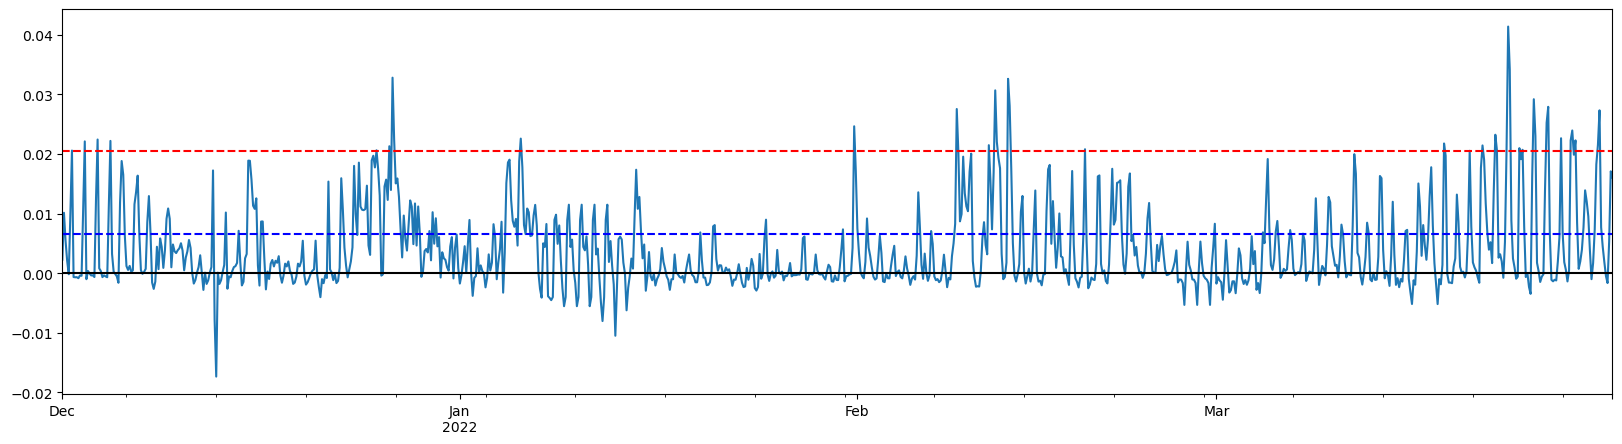

In [7]:
import matplotlib.pyplot as plt
fig, ax = plt.subplots(figsize=(20, 5))
# w22_sublimation[w22_sublimation>-0.05]['sublimation_prcp_0_5_mm'].plot(ax=ax)
w22_sublimation[w22_sublimation>-0.05]['sublimation_prcp_0_5_mm'].resample('3H').mean().plot(ax=ax)

# plot horizontal line at the 95th percentile
ax.axhline(w22_sublimation['sublimation_prcp_0_5_mm'].quantile(0.95), color='red', linestyle='--')
# plot horizontal line at the 75th percentile
ax.axhline(w22_sublimation['sublimation_prcp_0_5_mm'].quantile(0.75), color='blue', linestyle='--')

# plot horizaontal line at 0
ax.axhline(0, color='black', linestyle='-')

In [8]:
# make the index the day of water year
dowy = lambda x: x.dayofyear - 274 if x.dayofyear >= 274 else x.dayofyear + 91

def create_comparable_df_from_ds(ds, variable, agg_func='mean'):
    if agg_func == 'mean':
        df_var = ds[variable].groupby('time.date').mean().to_dataframe().reset_index()
    elif agg_func == 'max':
        df_var = ds[variable].groupby('time.date').max().to_dataframe().reset_index()
    else:
        raise ValueError('agg_func must be mean or max')
    df_var.index = pd.to_datetime(df_var['date']).apply(dowy)
    df_var['date'] = pd.to_datetime(df_var['date'])
    df_var.index.name = 'dowy'
    df_var = df_var.loc[0:]
    return df_var

def create_comparable_df_from_df(df):
    df_var = df.groupby(df.index.date).sum().reset_index()
    df_var.index = pd.to_datetime(df_var['index']).apply(dowy)
    df_var['date'] = pd.to_datetime(df_var['index'])
    df_var.index.name = 'dowy'
    df_var = df_var.loc[0:]
    return df_var

# create comparable dataframes for each variable
w22_mean_wspd = create_comparable_df_from_ds(w22_sail_met_qc_ds, 'wspd_arith_mean', 'mean')
w23_mean_wspd = create_comparable_df_from_ds(w23_sail_met_qc_ds, 'wspd_arith_mean', 'mean')
w22_max_wspd = create_comparable_df_from_ds(w22_sail_met_qc_ds, 'wspd_arith_mean', 'max')
w23_max_wspd = create_comparable_df_from_ds(w23_sail_met_qc_ds, 'wspd_arith_mean', 'max')
w22_mean_temperture = create_comparable_df_from_ds(w22_sail_met_qc_ds, 'temp_mean', 'mean')
w23_mean_temperture = create_comparable_df_from_ds(w23_sail_met_qc_ds, 'temp_mean', 'mean')
w22_mean_vapor_pressure_deficit = create_comparable_df_from_ds(w22_sail_met_qc_ds, 'vapor_pressure_deficit', 'mean')
w23_mean_vapor_pressure_deficit = create_comparable_df_from_ds(w23_sail_met_qc_ds, 'vapor_pressure_deficit', 'mean')

# Precipitation
w22_cumulative_precip = create_comparable_df_from_df(w22_pluvio)['SAIL_gts_pluvio'].cumsum()
w23_cumulative_precip = create_comparable_df_from_df(w23_pluvio)['SAIL_gts_pluvio'].cumsum()

# Sublimation
w22_cumulative_sublimation = create_comparable_df_from_df(w22_sublimation)['sublimation_prcp_0_5_mm'].cumsum()
w23_cumulative_sublimation = create_comparable_df_from_df(w23_sublimation)['sublimation_prcp_0_5_mm'].cumsum()

In [10]:
# print the mean for each variable
print(f'Winter 21/22 Mean Wind Speed: {w22_mean_wspd["wspd_arith_mean"].mean()}')
print(f'Winter 22/23 Mean Wind Speed: {w23_mean_wspd["wspd_arith_mean"].mean()}')
print(f'Winter 21/22 Max Wind Speed: {w22_max_wspd["wspd_arith_mean"].max()}')
print(f'Winter 22/23 Max Wind Speed: {w23_max_wspd["wspd_arith_mean"].max()}')
print(f'Winter 21/22 Mean Temperature: {w22_mean_temperture["temp_mean"].mean()}')
print(f'Winter 22/23 Mean Temperature: {w23_mean_temperture["temp_mean"].mean()}')
print(f'Winter 21/22 Mean Vapor Pressure: {w22_mean_vapor_pressure_deficit["vapor_pressure_deficit"].mean()}')
print(f'Winter 22/23 Mean Vapor Pressure: {w23_mean_vapor_pressure_deficit["vapor_pressure_deficit"].mean()}')
# print the cumulative sum for each variable
print(f'Winter 21/22 Cumulative Precipitation: {w22_cumulative_precip.max()}')
print(f'Winter 22/23 Cumulative Precipitation: {w23_cumulative_precip.max()}')
print(f'Winter 21/22 Cumulative Sublimation: {w22_cumulative_sublimation.max()}')
print(f'Winter 22/23 Cumulative Sublimation: {w23_cumulative_sublimation.max()}')


Winter 21/22 Mean Wind Speed: 1.1102908849716187
Winter 22/23 Mean Wind Speed: 1.1545082330703735
Winter 21/22 Max Wind Speed: 36.63999938964844
Winter 22/23 Max Wind Speed: 19.360000610351562
Winter 21/22 Mean Temperature: 4.795719623565674
Winter 22/23 Mean Temperature: 4.192263603210449
Winter 21/22 Mean Vapor Pressure: 101.48326110839844
Winter 22/23 Mean Vapor Pressure: 65.83181762695312
Winter 21/22 Cumulative Precipitation: 362.7499986639999
Winter 22/23 Cumulative Precipitation: 494.1799976799998
Winter 21/22 Cumulative Sublimation: 21.451045054685647
Winter 22/23 Cumulative Sublimation: 21.975611820836445


In [11]:
print(f'Percent of winter below freezing in 21/22: {w22_mean_temperture[w22_mean_temperture["temp_mean"] < 0].shape[0]/w22_mean_temperture.shape[0]*100:.2f}%')
print(f'Percent of winter below freezing in 22/23: {w23_mean_temperture[w23_mean_temperture["temp_mean"] < 0].shape[0]/w23_mean_temperture.shape[0]*100:.2f}%')

Percent of winter below freezing in 21/22: 92.56%
Percent of winter below freezing in 22/23: 99.17%


In [11]:
import re
def speed_label_to_val(label: str | pd.Interval) -> float:
    """
    Convert a speed‑bin label to a single numeric value.
      • "0-2"   → 1.0
      • "0–2"   → 1.0     (handles en dash too)
      • "14+"   → 14.0
      • "14>"   → 14.0
    If you ever pass a pandas Interval, it returns the
    midpoint or left edge (for an open‑ended bin).
    """
    # If it's an Interval object (from pd.cut without custom labels)
    if isinstance(label, pd.Interval):
        return label.left if label.right == np.inf else (label.left + label.right) / 2

    # Otherwise it's a plain string -------------------------------------------------
    s = str(label)

    # Case 1 ─ open‑ended:  "14+"  or  "14>"
    if '+' in s or '>' in s:
        return float(re.sub(r'[+>]', '', s))          # drop symbols, keep the number

    # Case 2 ─ bounded range:  "0‑2" or "0–2"
    left, right = re.split(r'[-–]', s)                # split on hyphen OR en dash
    return (float(left) + float(right)) / 2

In [12]:
# 2022 wind rose data
wspd_var = 'wind_spd'
wdir_var = 'wind_dir'
# create a windrose dataframe
w22_wind_rose_df = create_windrose_df(w22_sail_met_kp_qc_ds.to_dataframe()[[wspd_var, wdir_var]],
                                      wind_dir_var=wdir_var, 
                                      wind_spd_var=wspd_var,
                                      speed_bins=(0,2,4,6,8,10,12,14,50),
                                      speed_labels=('0-2','2-4','4-6','6-8','8-10','10-12','12-14','>14')
                                      )
w23_wind_rose_df = create_windrose_df(w23_sail_met_kp_qc_ds.to_dataframe()[[wspd_var, wdir_var]], 
                                      wind_dir_var=wdir_var, 
                                      wind_spd_var=wspd_var,
                                      speed_bins=(0,2,4,6,8,10,12,14,50),
                                      speed_labels=('0-2','2-4','4-6','6-8','8-10','10-12','12-14','>14'),
                                      )

for df in [w22_wind_rose_df, w23_wind_rose_df]:
    # convert the speed labels to values
    df['speed_vals'] = df['speed'].apply(speed_label_to_val)
    
    
type(w22_wind_rose_df['direction'].loc[0])

numpy.int64

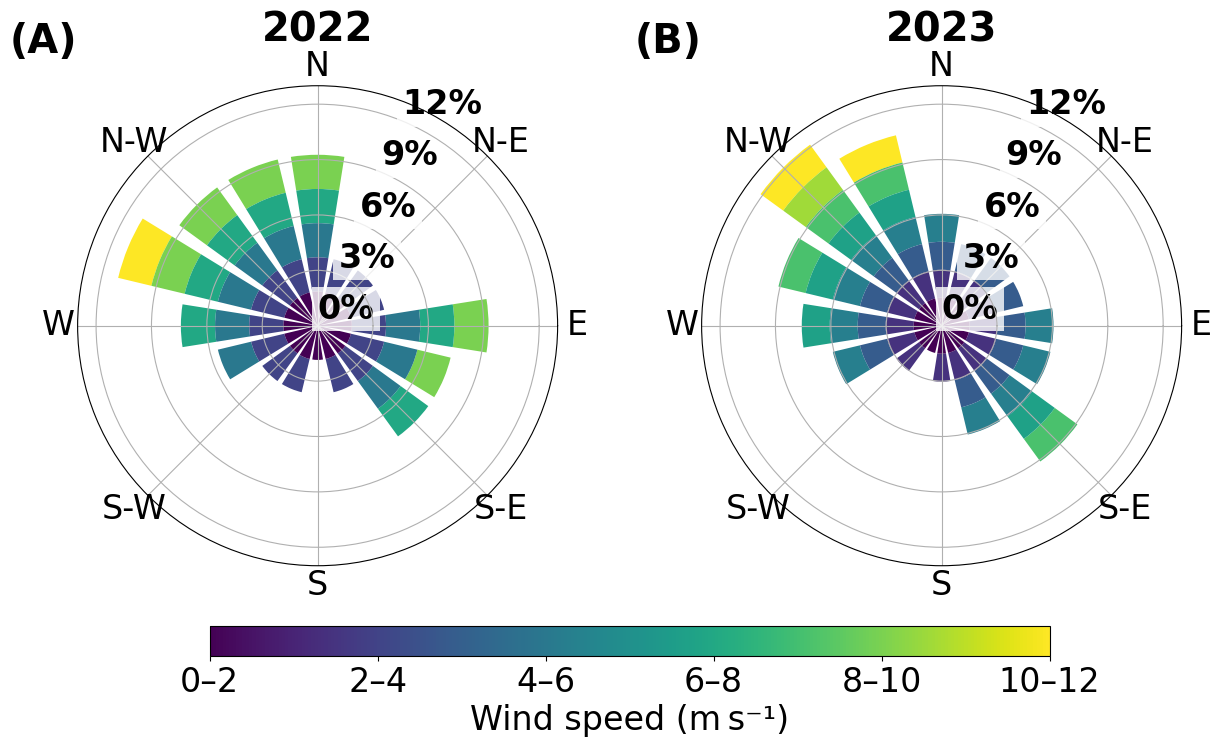

In [13]:
# ------------------------------------------------------------
# Master font size for every element in the figure
# ------------------------------------------------------------
plot_font_size = 24               # ← change this once, everything rescales
title_font_size = plot_font_size * 1.2

# ------------------------------------------------------------
# 2.  Plot the two wind roses, share one categorical colour‑bar
# ------------------------------------------------------------
with plt.rc_context({"font.size": plot_font_size}):        # apply size globally
    fig = plt.figure(figsize=(12, 6))

    # --- 2022 ---------------------------------------------------------
    ax1 = WindroseAxes.from_ax(fig=fig, rect=[0.04, 0.1, 0.40, 0.8])
    fig.add_axes(ax1)
    ax1.bar(
        w22_wind_rose_df["direction"],
        w22_wind_rose_df["speed_vals"],
        normed=True,
        opening=0.8,
        bins=np.unique(w22_wind_rose_df["speed_vals"]),
    )
    ax1.set_title("2022", fontsize=title_font_size,fontweight="bold")

    # --- 2023 ---------------------------------------------------------
    ax2 = WindroseAxes.from_ax(fig=fig, rect=[0.56, 0.1, 0.40, 0.8])
    fig.add_axes(ax2)
    ax2.bar(
        w23_wind_rose_df["direction"],
        w23_wind_rose_df["speed_vals"],
        normed=True,
        opening=0.8,
        bins=np.unique(w23_wind_rose_df["speed_vals"]),
    )
    ax2.set_title("2023", fontsize=title_font_size, fontweight="bold")

    # --- Shared categorical colour-bar along bottom ------------------------------
    cax = fig.add_axes([0.15, -0.05, 0.7, 0.05])  # [left, bottom, width, height]
    edges = np.unique(w22_wind_rose_df["speed_vals"])
    norm = plt.Normalize(vmin=edges.min(), vmax=edges.max())
    sm = plt.cm.ScalarMappable(norm=norm, cmap="viridis")
    sm.set_array([])

    cbar = fig.colorbar(sm, cax=cax, orientation="horizontal")
    cbar.set_ticks(edges)
    cbar.set_ticklabels([f"{int(x-1)}–{int(x+1)}" for x in edges])
    cbar.set_label("Wind speed (m s⁻¹)", fontsize=plot_font_size)
    cbar.ax.tick_params(labelsize=plot_font_size)

    # ------------------------------------------------------------
    # Style tweaks: bold interior radius labels, resize direction labels
    # ------------------------------------------------------------
    for ax in (ax1, ax2):
        # add (A) and (B) labels to the upper left corner of each subplot
        ax.text(0, 1.05, "(A)" if ax is ax1 else "(B)", 
                transform=ax.transAxes, fontsize=title_font_size, 
                fontweight="bold", va="bottom", ha="right")
        # Direction (theta) labels
        ax.tick_params(axis="x", labelsize=plot_font_size)
        # Interior radius (frequency) labels
        for ax in (ax1, ax2):
            ax.set_ylim(0, 13)                 # set max radius to 15
            ax.set_yticks(np.arange(0, 13, 3)) # ticks at 0,3,6,9,12,15
            ax.set_yticklabels([str(i)+"%" for i in range(0, 13, 3)], 
                               fontweight="bold", 
                               fontsize=plot_font_size,
                               # add white background to the labels
                               bbox=dict(facecolor='white', edgecolor='none', alpha=0.8))

    plt.show()

    # Save the figure
    fig.savefig('/home/dlhogan/GitHub/Synoptic-Sublimation/04_products/figures/draft/wind_rose.png', dpi=300,
                # add some area to the bbox
                bbox_inches='tight', pad_inches=0.1, transparent=True)


In [14]:
fig = make_subplots(rows=2, cols=1,
                    subplot_titles=("Winter 21/22",
                                    "Winter 22/23"),
                                    vertical_spacing=0.1)

# Cumulative Sublimation
fig.add_trace(go.Scatter(x=w22_cumulative_sublimation.index,
                            y=w22_cumulative_sublimation,
                            name='2021-2022',
                            marker_color='black',
                            showlegend=False,),
                            row=1, col=1)
fig.add_trace(go.Scatter(x=w23_cumulative_sublimation.index,
                            y=w23_cumulative_sublimation,
                            name='2022-2023',
                            marker_color='black',
                            showlegend=False,),
                            row=2, col=1)

fig.update_layout(
    title = '',
    yaxis1_title='Sublimation<br>(mm)',
    yaxis2_title='Sublimation<br>(mm)',
    # yaxis2_range=[0, 40],
    width=700,
    height=700,
    # decrease space between subplots
    
)
# update the xaxis to show months
fig.update_xaxes(
    ticktext=['Dec','Jan','Feb','Mar', 'Apr'],
    tickvals=[61, 92, 120, 151, 181],
    # set xlim to end at 215
    range=[61,181],
    # increase text size
    tickfont_size=16,
)
# update the yaxis to increase fontsize
fig.update_yaxes(
    title_font_size=18,
    tickfont_size=16,
)

In [74]:
fig = make_subplots(rows=4, cols=2,
                    specs=[[{}, {"rowspan": 2,
                                 "type":"polar"}],
                        [{}, None],
                        [{}, {"rowspan":2,
                              "type":"polar"}],
                        [{}, None]],
                    shared_xaxes=False,
                    vertical_spacing=0.1, 
                    subplot_titles=('(a)', 
                                    '(e) <br> ',
                                    '(b)',
                                    '(c)',
                                    '(f) <br> ',
                                    '(d)'))

# Mean Temperature Plot
fig.add_trace(go.Scatter(x=w22_mean_temperture.index, 
                         y=w22_mean_temperture['temp_mean'], 
                         name='2021-2022',
                         marker_color='red',
                         showlegend=False,
                         opacity=0.25),
                         row=1, col=1)
# add the total mean
fig.add_trace(go.Scatter(x=w22_mean_temperture.index,
                            y=w22_mean_temperture['temp_mean'].mean()*np.ones(len(w22_mean_temperture)),
                            name='2021-2022',
                            marker_color='red',
                            showlegend=True,
                            opacity=1.0,
                            line=dict(dash='solid',
                                      width=2)),
                            row=1, col=1)
fig.add_trace(go.Scatter(x=w23_mean_temperture.index,
                            y=w23_mean_temperture['temp_mean'],
                            name='2022-2023',
                            marker_color='black',
                            showlegend=False,
                            opacity=0.25),
                            row=1, col=1)
# add the total mean
fig.add_trace(go.Scatter(x=w23_mean_temperture.index,
                            y=w23_mean_temperture['temp_mean'].mean()*np.ones(len(w23_mean_temperture)),
                            name='2022-2023',
                            marker_color='black',
                            showlegend=True,
                            opacity=1.0,
                            line=dict(dash='solid',
                                      width=2)),
                            row=1, col=1)

# Mean Vapor Pressure Plot
fig.add_trace(go.Scatter(x=w22_mean_vapor_pressure_deficit.index, 
                         y=w22_mean_vapor_pressure_deficit['vapor_pressure_deficit'], 
                         name='2021-2022',
                         marker_color='red',
                         showlegend=False,
                         opacity=0.25),
                         row=2, col=1)
# add the total mean
fig.add_trace(go.Scatter(x=w22_mean_vapor_pressure_deficit.index,
                            y=w22_mean_vapor_pressure_deficit['vapor_pressure_deficit'].mean()*np.ones(len(w22_mean_vapor_pressure_deficit)),
                            name='2021-2022 Mean',
                            marker_color='red',
                            showlegend=False,
                            line=dict(dash='solid',
                                      width=2)),
                            row=2, col=1)   
fig.add_trace(go.Scatter(x=w23_mean_vapor_pressure_deficit.index,
                            y=w23_mean_vapor_pressure_deficit['vapor_pressure_deficit'],
                            name='2022-2023',
                            marker_color='black',
                            opacity=0.25,
                            showlegend=False,),
                            row=2, col=1)
# add the total mean
fig.add_trace(go.Scatter(x=w23_mean_vapor_pressure_deficit.index,
                            y=w23_mean_vapor_pressure_deficit['vapor_pressure_deficit'].mean()*np.ones(len(w23_mean_vapor_pressure_deficit)),
                            name='2022-2023 Mean',
                            marker_color='black',
                            showlegend=False,
                            line=dict(dash='solid',
                                      width=2)),
                            row=2, col=1)  

# Cumulative Precipitation
fig.add_trace(go.Scatter(x=w22_cumulative_precip.index, 
                         y=w22_cumulative_precip, 
                         name='2021-2022',
                         marker_color='red',
                         showlegend=False,),
                         row=3, col=1)
fig.add_trace(go.Scatter(x=w23_cumulative_precip.index,
                            y=w23_cumulative_precip,
                            name='2022-2023',
                            marker_color='black',
                            showlegend=False,),
                            row=3, col=1)
# Cumulative Sublimation
fig.add_trace(go.Scatter(x=w22_cumulative_sublimation.index,
                            y=w22_cumulative_sublimation,
                            name='2021-2022',
                            marker_color='red',
                            showlegend=False,),
                            row=4, col=1)
fig.add_trace(go.Scatter(x=w23_cumulative_sublimation.index,
                            y=w23_cumulative_sublimation,
                            name='2022-2023',
                            marker_color='black',
                            showlegend=False,),
                            row=4, col=1)

# Wind Rose 2022
fig.add_trace(
    go.Barpolar(
        r=w22_wind_rose_dir_df['frequency'].values,
        theta=w22_wind_rose_dir_df['direction'].values,
        marker_color='red',
        opacity=0.5,
        name='',
        showlegend=False,
    ),
    row=1, col=2
)

# Wind Rose 2023
fig.add_trace(
    go.Barpolar(
        r=w23_wind_rose_dir_df['frequency'].values,
        theta=w23_wind_rose_dir_df['direction'].values,
        marker_color='black', #marker_color is a function of radius
        opacity=0.5,
        showlegend=False,
    ),
    row=1, col=2
)

# Add high wind data

fig.add_trace(
    go.Barpolar(
        r=w22_wind_rose_spd_df['frequency'].values,
        theta=w22_wind_rose_spd_df['direction'].values,
        marker_color='red', #marker_color is a function of radius
        opacity=0.5,
        showlegend=False,
    ),
    row=3, col=2
)
# Wind Rose 2023

fig.add_trace(
    go.Barpolar(
        r=w23_wind_rose_spd_df['frequency'].values,
        theta=w23_wind_rose_spd_df['direction'].values,
        marker_color='black',
        opacity=0.5,
        name='',
        showlegend=False,
    ),
    row=3, col=2
)

axis1_range = [0,w22_wind_rose_dir_df[['frequency','direction']].groupby('direction', observed=True).sum().max().round(-1).item() + 10]
axis1_tickvals = np.arange(0, w22_wind_rose_dir_df[['frequency','direction']].groupby('direction', observed=True).sum().max().round(-1).item() + 10, 10).astype(int)
axis1_ticktext = [f'{val}%' for val in axis1_tickvals]

axis2_range = [0,w22_wind_rose_spd_df[['frequency','direction']].groupby('direction', observed=True).sum().max().round(-1).item()]
axis2_tickvals = np.arange(0, w22_wind_rose_spd_df[['frequency','direction']].groupby('direction', observed=True).sum().max().round(-1).item(), 5).astype(int)
axis2_ticktext = [f'{val}%' for val in axis2_tickvals]

fig.update_layout(
    title = '',
    yaxis1_title='Temperature<br>(&deg;C)',
    yaxis2_title='Vapor Pressure Deficit<br>(Pa)',
    yaxis3_title='Precipitation<br>(mm)',
    yaxis4_title='Sublimation<br>(mm)',
    xaxis4_title='Day of Year',
    polar1=dict(
        barmode='overlay',
        radialaxis_tickfont_size=18,
        radialaxis_range=axis1_range,
        radialaxis_tickvals=axis1_tickvals,
        radialaxis_ticktext=axis1_ticktext,
        angularaxis=dict(
            tickmode='array',
            rotation=90,
            tickfont_size=16,
            direction='clockwise'
        )),
    polar2=dict(
        barmode='overlay',
        radialaxis_tickfont_size=18,
        radialaxis_range=axis2_range,
        radialaxis_tickvals=axis2_tickvals,
        radialaxis_ticktext=axis2_ticktext,
        angularaxis=dict(
            tickmode='array',
            tickfont_size=16,
            rotation=90,
            direction='clockwise'
        )),
    legend1_title='Winter',
    # update the ylims
    yaxis1_range=[-23, 5],
    # yaxis2_range=[0, 40],
    width=1000,
    height=900,
)
# update the xaxis to show months
fig.update_xaxes(
    ticktext=['Dec','Jan','Feb','Mar', 'Apr'],
    tickvals=[61, 92, 120, 151, 181],
    # set xlim to end at 215
    range=[61,181],
    # increase text size
    tickfont_size=16,
)
# update the yaxis to increase fontsize
fig.update_yaxes(
    title_font_size=18,
    tickfont_size=16,
)
# move legend to the top
fig.update_layout(legend=dict(
    orientation="h",
    yanchor="bottom",
    y=1.07,
    xanchor="right",
    x=0.4,
    font_size=16,
    title_font_size=20,
))
# format the hover text
fig.update_traces(hovertemplate='Day of Water Year: %{x}<br>Wind Speed: %{y:.2f} m/s', row=1, col=1)
save_figure = True
if save_figure:
    # save figure as png
    fig.write_image(f'./04_products/figures/draft/w22_w23_met_comparison.png')    

In [72]:
fig